[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ryanharvey1/neuro_py/blob/main/tutorials/bias_correlation.ipynb)
&nbsp;
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/ryanharvey1/neuro_py/main/tutorials/bias_correlation.ipynb)
&nbsp;
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ryanharvey1/neuro_py/main?labpath=tutorials%2Fbias_correlation.ipynb)

# Pairwise Bias Correlation Analysis 

In this tutorial, we'll explore how to use the [`PairwiseBias`](https://ryanharvey1.github.io/neuro_py/reference/neuro_py/ensemble/replay/#neuro_py.ensemble.replay.PairwiseBias) class to analyze neural replay events. We'll simulate spike data for both task and post-task periods, and then use the PairwiseBias transformer to detect significant replay events.

---

## Setup

First, let's import the necessary libraries and set up our environment.

In [ ]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from neuro_py.ensemble.replay import PairwiseBias

# Set random seed for reproducibility
np.random.seed(0)

## Section 1: Simulate Data

### Section 1.1: Simulating Task Spike Data

We'll start by simulating spike data for a task period. This will represent the
original neural activity that we want to detect in replay events.

In [2]:
def simulate_sequential_spikes(
    nneurons=30,
    minseqduration=.05,
    maxseqduration=.15,
    duration=1.0,
    jitter=.01,
    random=False,
):
    spikes = []
    neuron_ids = []
    max_nsequences = np.ceil(duration / minseqduration)
    sequence_durations = np.random.uniform(
        minseqduration, maxseqduration, int(max_nsequences))
    # get index of last sequence that fits into duration
    last_sequence = np.where(np.cumsum(sequence_durations) <= duration)[0][-1]
    sequence_durations = sequence_durations[:last_sequence+1]
    sequence_epochs = np.cumsum(sequence_durations)
    sequence_epochs = np.asarray((
        np.r_[0, sequence_epochs][:-1],
        sequence_epochs
    )).T  # shape (nsequences, 2)

    for seq_start, seq_end in sequence_epochs:
        spike_ts = np.linspace(seq_start, seq_end, nneurons)
        # add jitter
        spike_ts += np.random.uniform(-jitter, jitter, nneurons)
        spike_ts = np.sort(spike_ts)
        # clip to sequence bounds
        spike_ts = np.clip(spike_ts, seq_start, seq_end)
        spikes.append(spike_ts)
        neuron_ids.append(np.arange(nneurons))

    spikes = np.concatenate(spikes)
    neuron_ids = np.concatenate(neuron_ids)

    if random:
        neuron_ids = np.random.permutation(neuron_ids)

    return spikes, neuron_ids, sequence_epochs

Set parameters for simulation of spike data.

In [3]:
nneurons = 15
minseqduration = .05
maxseqduration = .15
duration = .5

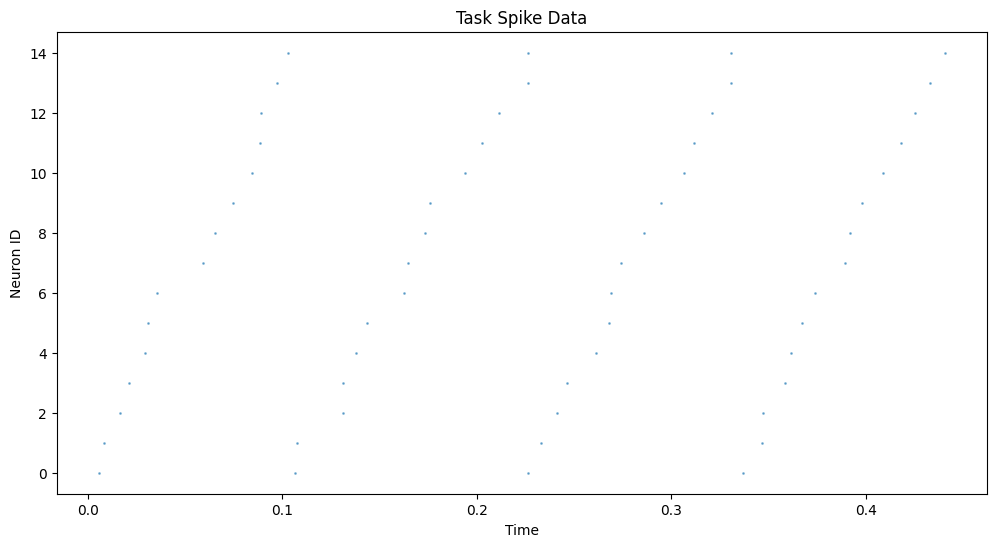

In [4]:
task_spikes, task_neurons, task_seq_epochs = simulate_sequential_spikes(
    nneurons=nneurons,
    minseqduration=minseqduration,
    maxseqduration=maxseqduration,
    duration=duration,
    random=False
)

# Visualize task spike data
plt.figure(figsize=(12, 6))
plt.scatter(task_spikes, task_neurons, alpha=0.5, s=1)
plt.title("Task Spike Data")
plt.xlabel("Time")
plt.ylabel("Neuron ID")
plt.show()

### Section 1.2: Simulating Post-Task Spike Data

Now, let's simulate post-task spike data for both significant and
non-significant replay scenarios, and visualize them.

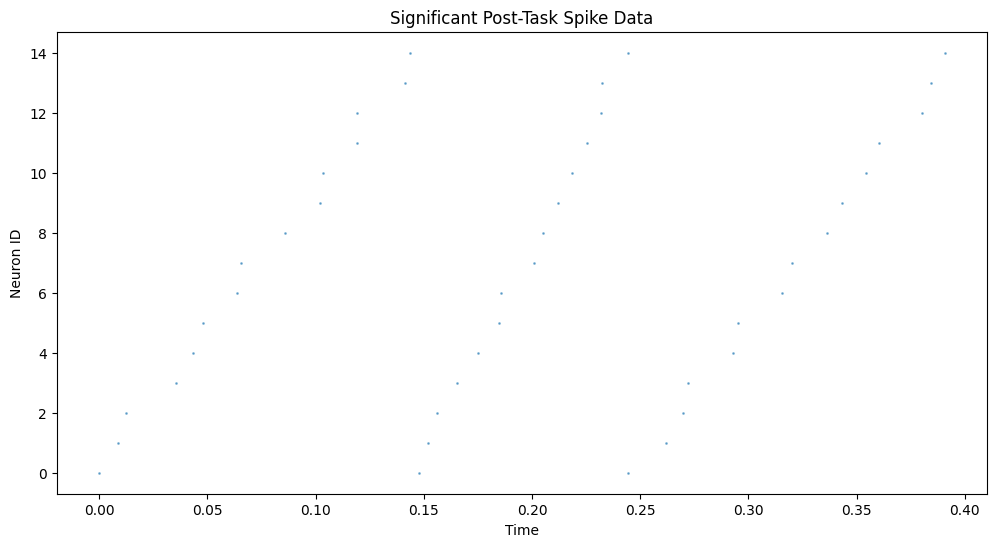

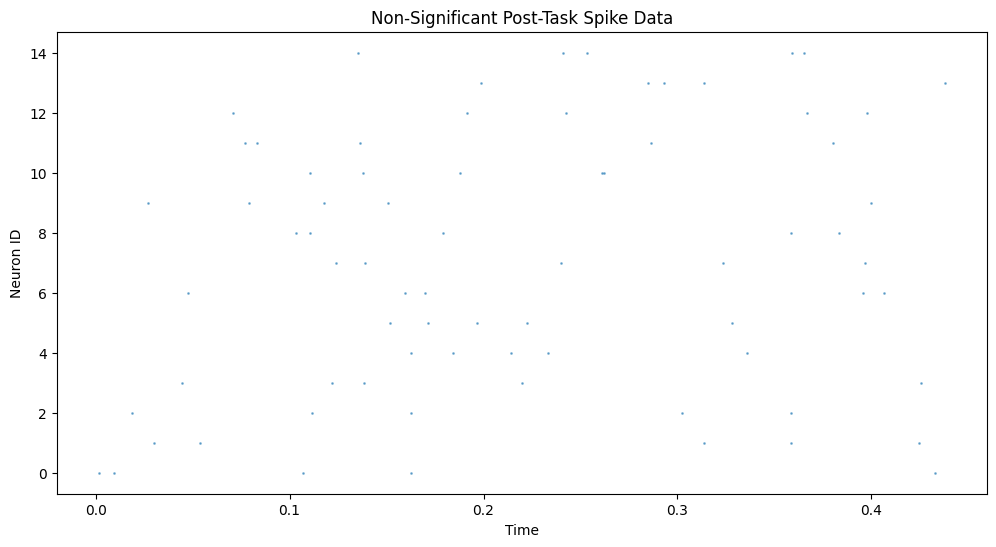

In [5]:
post_spikes_sig, post_neurons_sig, post_sig_seq_epochs = simulate_sequential_spikes(
    nneurons=nneurons,
    minseqduration=minseqduration,
    maxseqduration=maxseqduration,
    duration=duration,
    random=False
)
post_spikes_nonsig, post_neurons_nonsig, post_nonsig_seq_epochs = simulate_sequential_spikes(
    nneurons=nneurons,
    minseqduration=minseqduration,
    maxseqduration=maxseqduration,
    duration=duration,
    random=True
)

# Visualize significant post-task spike data
plt.figure(figsize=(12, 6))
plt.scatter(post_spikes_sig, post_neurons_sig, alpha=0.5, s=1)
plt.title("Significant Post-Task Spike Data")
plt.xlabel("Time")
plt.ylabel("Neuron ID")
plt.show()

# Visualize non-significant post-task spike data
plt.figure(figsize=(12, 6))
plt.scatter(post_spikes_nonsig, post_neurons_nonsig, alpha=0.5, s=1)
plt.title("Non-Significant Post-Task Spike Data")
plt.xlabel("Time")
plt.ylabel("Neuron ID")
plt.show()

## Section 2: Analyzing Replay with PairwiseBias

Now that we have our simulated data, let's use the PairwiseBias transformer to
analyze replay events.

In [6]:
transformer = PairwiseBias()

# Analyze significant replay
z_score_sig, p_value_sig, cosine_val_sig = transformer.fit_transform(
    task_spikes, task_neurons, task_seq_epochs,
    post_spikes_sig, post_neurons_sig, post_sig_seq_epochs
)

print("Significant Replay Results:")
print(f"Z-scores: {z_score_sig}")
print(f"P-values: {p_value_sig}")
print(f"Cosine values: {cosine_val_sig}")

# Analyze non-significant replay
z_score_nonsig, p_value_nonsig, cosine_val_nonsig = transformer.transform(
    post_spikes_nonsig, post_neurons_nonsig, post_nonsig_seq_epochs
)

print("\nNon-significant Replay Results:")
print(f"Z-scores: {z_score_nonsig}")
print(f"P-values: {p_value_nonsig}")
print(f"Cosine values: {cosine_val_nonsig}")

Significant Replay Results:
Z-scores: [5.11955543 4.89301241 4.96743712]
P-values: [0.00332226 0.00332226 0.00332226]
Cosine values: [0.99931389 0.92518489 0.99931389]

Non-significant Replay Results:
Z-scores: [ 1.7207632  -0.25081679  0.99356616 -1.8836596  -2.84660899]
P-values: [0.03986711 0.61129568 0.16611296 0.97674419 1.        ]
Cosine values: [ 0.25603607 -0.03190925  0.14527121 -0.32232919 -0.41384394]


## Section 3: Visualizing Results

Let's create a simple visualization to compare the significant and
non-significant replay results.

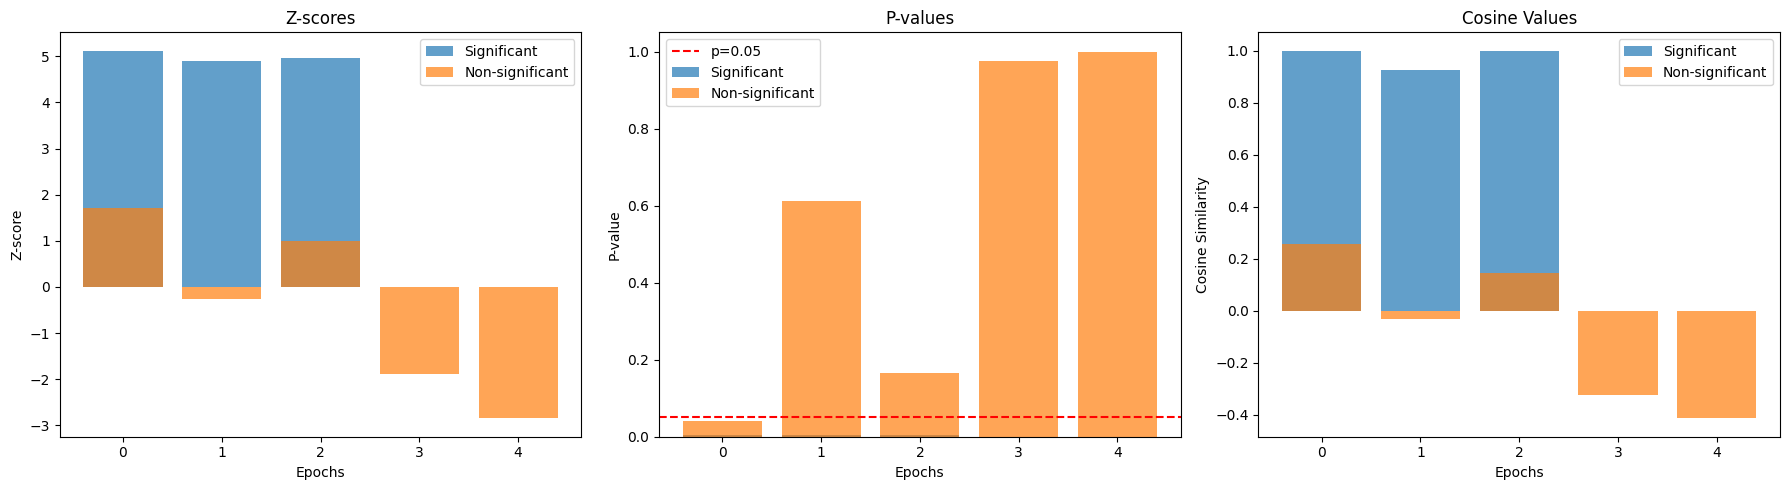

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.bar(range(len(z_score_sig)), z_score_sig, alpha=0.7, label='Significant')
ax1.bar(range(len(z_score_nonsig)), z_score_nonsig, alpha=0.7, label='Non-significant')
ax1.set_title('Z-scores')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Z-score')
ax1.legend()

ax2.bar(range(len(p_value_sig)), p_value_sig, alpha=0.7, label='Significant')
ax2.bar(range(len(p_value_nonsig)), p_value_nonsig, alpha=0.7, label='Non-significant')
ax2.set_title('P-values')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('P-value')
ax2.axhline(y=0.05, color='r', linestyle='--', label='p=0.05')
ax2.legend()

ax3.bar(range(len(cosine_val_sig)), cosine_val_sig, alpha=0.7, label='Significant')
ax3.bar(range(len(cosine_val_nonsig)), cosine_val_nonsig, alpha=0.7, label='Non-significant')
ax3.set_title('Cosine Values')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Cosine Similarity')
ax3.legend()

plt.tight_layout()
plt.show()

## Section 4: Conclusion

In this tutorial, we've demonstrated how to use the `PairwiseBias` class to
analyze neural replay events. We simulated task and post-task spike data, and
then used the transformer to detect significant replay events. The results show
that our method can effectively distinguish between significant and
non-significant replay, as evidenced by the Z-scores and p-values.

Key observations:

1. The task spike data visualization shows a clear sequential pattern across
neurons.
2. The significant post-task spike data maintains a similar sequential pattern,
while the non-significant data appears more random.
3. For significant replay, we see high Z-scores and low p-values (p < 0.05).
4. For non-significant replay, we see mostly lower Z-scores and higher p-values
(p > 0.05).



---